In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# a vaguely realistic, slightly non-trivial model
from scipy.special import expit
def testmodel(t, tmid=234, tau0=25, tau1=5, nmax=2345):
    tau = tau0 + tau1 * t / tau0
    x = (t - tmid) / tau
    y = nmax * expit(x)
    #y = y.round().astype(np.int)
    return y

In [3]:
# high resolution truth for plotting
t_plot = np.linspace(0, 500, 100)
y_true_plot = testmodel(t_plot)

In [4]:
# truth sampled at random set of times
nsamp = 50
tmax = 200
t = np.sort(np.random.choice(tmax, nsamp, replace=False).round().astype(np.int))
y_true = testmodel(t).round().astype(np.int)

In [5]:
# simulate noisy observations by treating differential counts as Poisson
yd_true = np.diff(y_true)
yd_obs = np.random.poisson(yd_true)
y_obs = np.concatenate(([0], yd_obs.cumsum()))

In [6]:
# examine distribution of (observed - truth) residuals
yd_obs_ensemble = np.random.poisson(yd_true, (1000,) + yd_true.shape)
y_obs_ensemble = np.concatenate((np.zeros((1000, 1)), yd_obs_ensemble.cumsum(axis=-1)), axis=1)
y_res = y_obs_ensemble - y_true
s_obs_true = y_res.std(axis=0)

In [7]:
# consider rates
from scipy.misc import derivative
tr = 0.5*(t[:-1] + t[1:])
r_true_plot = derivative(testmodel, t_plot)
r_true = derivative(testmodel, tr)
r_obs = np.diff(y_obs) / np.diff(t)

In [43]:
r_obs_ensemble[126]

array([  0.        ,   0.75      ,   0.        ,   0.        ,
         0.        ,   0.36363636,   0.6       ,   0.        ,
         0.        ,   1.        ,   0.        ,   1.        ,
         0.        ,   2.        ,   0.3       ,   0.875     ,
         1.5       ,   2.        ,   2.        ,   2.        ,
         4.        ,   1.8       ,   1.        ,   2.        ,
         2.        ,   2.5       ,   2.33333333,   3.33333333,
         2.6       ,   1.        ,   4.71428571,   6.66666667,
         6.71428571,   7.        ,   9.        ,   7.25      ,
         6.8       ,   8.3       ,  10.        ,   9.        ,
        12.        ,   4.        ,   6.66666667,   9.35714286,
        11.        ,   7.        ,  11.77777778,  10.5       ,  10.        ])

In [8]:
# examine distribution of (observed - truth) residuals
r_obs_ensemble = np.diff(yd_obs_ensemble, axis=1) / np.diff(t)
r_res = r_obs_ensemble - r_true
sr_obs_true = r_res.std(axis=0)

In [73]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
kernel = (1 * RBF(length_scale=10.0, length_scale_bounds=(1, 1e3)) +
          WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e+1)))
reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True)

In [74]:
tr_fit = np.concatenate(([-1], tr))
r_fit = np.concatenate(([0], r_obs))

In [75]:
reg.fit(tr_fit.reshape(-1, 1), r_fit)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=10) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [76]:
reg.kernel_

3.76**2 * RBF(length_scale=89.5) + WhiteKernel(noise_level=1.19)

In [77]:
r_reg = reg.predict(tr.reshape(-1, 1))
r_reg_plot = reg.predict(t_plot.reshape(-1, 1))

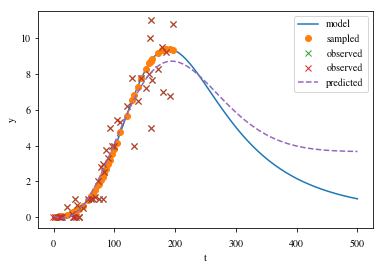

In [78]:
plt.plot(t_plot, r_true_plot, label='model')
plt.plot(tr, r_true, 'o', label='sampled')
plt.plot(tr, r_obs, 'x', label='observed')
plt.plot(tr_fit, r_fit, 'x', label='observed')
plt.plot(t_plot, r_reg_plot, '--', label='predicted')
plt.ylabel('y')
plt.xlabel('t')
plt.legend();

In [15]:
from sklearn.isotonic import IsotonicRegression
reg = IsotonicRegression(out_of_bounds='clip')

In [16]:
reg.fit(t, y_obs)

IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
          y_min=None)

In [17]:
y_reg = reg.predict(t).round().astype(np.int)
y_reg_plot = reg.predict(t_plot).round().astype(np.int)

In [18]:
(y_reg == y_obs).all()

True

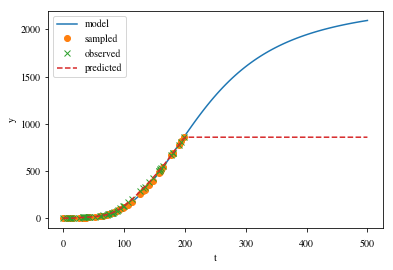

In [19]:
plt.plot(t_plot, y_true_plot, label='model')
plt.plot(t, y_true, 'o', label='sampled')
plt.plot(t, y_obs, 'x', label='observed')
plt.plot(t_plot, y_reg_plot, '--', label='predicted')
plt.ylabel('y')
plt.xlabel('t')
plt.legend();

In [20]:
def bootstrap(t, y, reg, reg2d=True, n_bs=100):
    # predict y for each value of t by fitting bootstrap samples
    # that do _not_ include the value of t in question
    y_bs_reg = np.zeros((n_bs, len(t)))
    for j in range(len(t)):
        yj = np.delete(y, j)
        bs_idx = np.random.choice(len(yj), (n_bs, len(y)))
        bs_idx.sort(axis=-1)
        t_bs = t[bs_idx]
        y_bs = y[bs_idx]
        for i in range(n_bs):
            tfit = t_bs[i]
            tpred = t[j:j+1]
            if reg2d:
                tfit = tfit.reshape(-1, 1)
                tpred = tpred.reshape(-1, 1)
            # fit to bs samples
            reg.fit(tfit, y_bs[i])
            # predict at observed times
            y_bs_reg[i, j] = reg.predict(tpred).round().astype(np.int)
    return y_bs_reg

In [28]:
kernel = (1.0 * RBF(length_scale=10.0, length_scale_bounds=(1e-2, 1e3)) +
          WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)))
reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
reg.fit(tr_fit.reshape(-1, 1), r_fit)
print(reg.kernel_)
reg.optimizer = None
r_bs_reg = bootstrap(tr_fit, r_fit, reg)

3.76**2 * RBF(length_scale=89.5) + WhiteKernel(noise_level=1.19)


In [29]:
r_bs_reg = r_bs_reg[:, 1:]

In [30]:
sr_bs = r_bs_reg.std(axis=0)

In [31]:
sr_bs.round(2)

array([ 0.63,  0.58,  0.52,  0.54,  0.48,  0.22,  0.29,  0.44,  0.5 ,
        0.51,  0.48,  0.5 ,  0.48,  0.46,  0.31,  0.51,  0.54,  0.54,
        0.49,  0.42,  0.37,  0.33,  0.49,  0.45,  0.42,  0.38,  0.47,
        0.22,  0.42,  0.48,  0.49,  0.36,  0.63,  0.9 ,  0.81,  0.65,
        0.66,  0.69,  0.74,  0.79,  0.87,  0.94,  0.85,  0.68,  0.9 ,
        0.85,  0.82,  0.78,  0.82])

In [ ]:
# Expected Poisson error

In [32]:
sr_obs_true.round(2)

array([ 0.  ,  0.24,  0.  ,  0.  ,  0.  ,  0.12,  0.2 ,  0.  ,  0.  ,
        0.5 ,  0.  ,  0.47,  0.  ,  0.98,  0.24,  0.36,  0.87,  0.68,
        0.48,  0.87,  1.4 ,  0.65,  1.39,  1.39,  1.09,  0.8 ,  1.  ,
        1.  ,  0.85,  1.94,  0.78,  0.87,  0.63,  1.09,  1.86,  0.96,
        1.28,  0.93,  2.9 ,  2.75,  3.03,  2.94,  1.75,  0.82,  2.16,
        2.97,  1.  ,  1.5 ,  1.37])

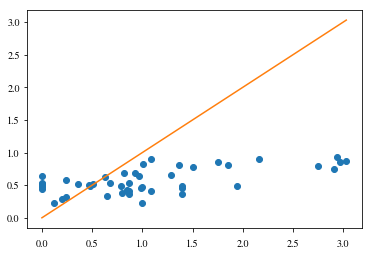

In [33]:
plt.plot(sr_obs_true, sr_bs, 'o')
upper = max(sr_obs_true.max(), sr_bs.max())
plt.plot([0, upper], [0, upper])